# Stat 301 Project
#### **Group Number:** [36] ####


---

### Section 0: TA Feedback (Stage 1 Report)

**Score:** 27.5 / 30

**TA Feedback (Point Form):**
- Variable description: Some variables were labeled with incorrect types. For example, *OperatingSystems* should be described as categorical, even though it is encoded as integers.
- Data source: Include a direct link to the dataset source.
- Pre-selection of variables: Correlation between duration variables (e.g., Administrative vs. Administrative_Duration) should be examined using EDA, rather than assumed.
- Scientific question: Should incorporate as many input variables as possible, not just a subset.
- Visualization interpretation: The statement “Returning visitors show more purchase sessions than new visitors” is not clearly supported by the scatterplot.
- Coding: Add comments explaining each code chunk.

---

In [36]:
library(tidyverse)
library(cowplot)
library(repr)
library(infer)
library(broom)
library(AER)
library(modelr)

#### We first filter out the correct data we will be using (since we are in Group 36, we are only using `Region` == 1 portion of the dataset).

In [37]:
origin <- read_csv("online_shoppers_intention.csv")
osi <- origin|>
    filter(Region == 1)

Rows: 12330 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Month, VisitorType
dbl (14): Administrative, Administrative_Duration, Informational, Informatio...
lgl  (2): Weekend, Revenue

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



### Section 1: Data Description

- The dataset used in this project is the Online Shoppers Purchasing Intention Dataset, which contains information on user behavior collected from an e-commerce website, available from the UCI Machine Learning Repository:
****Link:** https://archive.ics.uci.edu/dataset/512/online+shoppers+intention**
- After filtering for Region = 1, the dataset contains 4,780 observations and 18 variables.
- Each row represents a user session, and each column describes a session-level attribute such as browsing activity, engagement, and purchase behavior.

**Summary of Variables:**

| Variable | Type | Description |
|-----------|------|-------------|
| Administrative | Integer | Number of administrative pages visited by the user. |
| Administrative_Duration | Numeric | Time spent on administrative pages (in seconds). |
| Informational | Integer | Number of informational pages visited. |
| Informational_Duration | Numeric | Time spent on informational pages. |
| ProductRelated | Integer | Number of product-related pages visited. |
| ProductRelated_Duration | Numeric | Time spent on product-related pages. |
| BounceRates | Numeric | The percentage of visitors who navigate away from the site after viewing only one page. |
| ExitRates | Numeric | The average rate at which visitors exit the website. |
| PageValues | Numeric | The estimated monetary value for a page. |
| SpecialDay | Numeric | Closeness to a special day, holidays for example. |
| Month | Categorical | Month of the visit. |
| **OperatingSystems** | Categorical | Encoded operating system used by the visitor. |
| **Browser** | Categorical | Encoded ID of the browser used. |
| Region | Categorical | Encoded ID of the visitor’s region. We only consider Region == 1 in our analysis. |
| TrafficType | Categorical | Encoded ID of the traffic source. |
| VisitorType | Categorical | Returning or new visitor, "other" is also contained. |
| Weekend | Boolean | Whether the visit occurred on a weekend. |
| Revenue | Boolean | Whether the visitor completed a purchase. |

**Source and Information:**
- Source: UCI Machine Learning Repository — “Online Shoppers Purchasing Intention Dataset”.
- Data collected from a real e-commerce website over one year (May 2015 – May 2016).
- Each record corresponds to a single session and includes behavioral metrics, technical attributes, and purchase outcome.

**Pre-selection of Variables:**
- Only the `Region` variable is removed since it is constant after filtering to Region == 1.  
- **Variables such as `Administrative` and `Administrative_Duration` may be correlated; this will be tested in later EDA steps.**
- All remaining variables will be retained initially for exploration since they may influence user purchasing behavior.

---

### Section 2: Scientific Question

**Scientific Question:**  
**How do users’ browsing behaviours (Administrative, Informational, and ProductRelated page visits and durations), combined with engagement and contextual factors (ExitRates, PageValues, SpecialDay, OperatingSystems, Browser, and TrafficType), influence the likelihood that a shopper completes a purchase on the website?**

**In this stage, we will be mainly focusing on "How do browsing behavior (page views, durations, exit rates), visitor characteristics (visitor type), and engagement metrics relate to the likelihood of making a purchase (Revenue)?”.**

**Response Variable:**  
`Revenue` — a binary variable indicating whether the session resulted in a purchase (`TRUE` = purchase made, `FALSE` = no purchase).

**Explanatory Variables:**  
- `VisitorType` (categorical): indicates whether the user is a *New Visitor* (the user is visiting for the first time) or a *Returning Visitor* (the user has visited the site before). Other doesn't make sense in this case since an user either visited this site the first time or not, thus we will exclude these observations.  
- `ExitRates` (numerical): proportion of exits relative to page views during the session.
- `PageValues` (numerical): estimated value of viewed pages

**Focus:**  
This question mostly focuses on *inference*, it aims to understand how `VisitorType`, `ExitRates`, and `PageValues` are associated with the likelihood of a purchase (`Revenue`). It is not primarily about predicting future purchases, but about interpreting the relationships between the variables.

### EDA Step (**Revision**)

To determine whether some variables in the dataset are highly correlated, we conducted two standard EDA procedures:
**Correlation Matrix**  
   We computed a correlation matrix using only numerical variables. This allows us to detect strong linear relationships that may lead to multicollinearity during modeling.


In [38]:
# --- Correlation Matrix ---
# Prepare filtered dataset for visualization later
osi <- read_csv("online_shoppers_intention.csv") |>
  filter(Region == 1, VisitorType != "Other") |>     # remove region 1 only
  select(-Region)

# Select only numeric variables
numeric_osi <- osi |>
  select(where(is.numeric))

# Compute the correlation matrix
cor_matrix <- cor(numeric_osi, use = "pairwise.complete.obs")

cor_matrix

Rows: 12330 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Month, VisitorType
dbl (14): Administrative, Administrative_Duration, Informational, Informatio...
lgl  (2): Weekend, Revenue

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,TrafficType
Administrative,1.000000000,0.592880415,0.377881882,0.2700051369,0.428070182,0.3677840636,-0.221688277,-0.314086836,0.1147238661,-0.10780560,-0.0108494307,0.005348534,-0.0236933749
Administrative_Duration,0.592880415,1.000000000,0.339296771,0.3134891629,0.328261590,0.4420716460,-0.133165792,-0.187197730,0.0730764817,-0.08080648,-0.0179565279,-0.004858965,-0.0036954041
Informational,0.377881882,0.339296771,1.000000000,0.6127145596,0.407130616,0.4248404005,-0.118868380,-0.163381314,0.0632136603,-0.05586266,-0.0034687531,-0.035146638,-0.0217996892
Informational_Duration,0.270005137,0.313489163,0.612714560,1.0000000000,0.354532849,0.4382984706,-0.076694197,-0.101871326,0.0337185980,-0.04268435,-0.0003140897,-0.009855085,-0.0038618936
ProductRelated,0.428070182,0.328261590,0.407130616,0.3545328493,1.000000000,0.8634198227,-0.194794590,-0.279654332,0.0436419856,-0.05341984,0.0072482679,-0.013608925,-0.0372195885
ProductRelated_Duration,0.367784064,0.442071646,0.424840400,0.4382984706,0.863419823,1.0000000000,-0.167435009,-0.228673666,0.0389345407,-0.06029288,-0.0000546469,-0.016802599,-0.0289697495
BounceRates,-0.221688277,-0.133165792,-0.118868380,-0.0766941969,-0.194794590,-0.1674350092,1.000000000,0.911110525,-0.1186487119,0.09378292,0.0049310767,-0.026220889,0.0748495456
ExitRates,-0.314086836,-0.187197730,-0.163381314,-0.1018713256,-0.279654332,-0.2286736656,0.911110525,1.000000000,-0.1736661639,0.12353090,-0.0045363265,-0.016705229,0.0691717730
PageValues,0.114723866,0.073076482,0.063213660,0.0337185980,0.043641986,0.0389345407,-0.118648712,-0.173666164,1.0000000000,-0.06880923,-0.0184902540,0.026084689,-0.0002475879
SpecialDay,-0.107805603,-0.080806483,-0.055862658,-0.0426843526,-0.053419843,-0.0602928785,0.093782920,0.123530899,-0.0688092335,1.00000000,0.0171885976,0.039544501,0.0722721416


#### Highly Correlated Variables 

From the correlation matrix, we identify two pairs of variables with strong correlations (|r| ≥ 0.70):

- **ProductRelated** and **ProductRelated_Duration**  
  - Correlation: **0.863**  
  - This indicates that users who view more product-related pages also spend more time on these pages.

- **BounceRates** and **ExitRates**  
  - Correlation: **0.911**  
  - This shows that sessions with high bounce rates also tend to have high exit rates.

These strong correlations suggest that the variables in each pair provide similar information. In later modeling steps, it may be beneficial to remove or combine these variables to avoid multicollinearity.


In [39]:
# ProductRelated_Duration is highly correlated with ProductRelated
# BounceRates is highly correlated with ExitRates

vars_to_remove <- c("ProductRelated_Duration", "BounceRates")

# Remove them from the numeric dataset
numeric_osi_clean <- numeric_osi |>
  select(!all_of(vars_to_remove))

# If you want to remove them from the full dataset as well:
osi <- osi |>
  select(!all_of(vars_to_remove))

### Section 3: Exploratory Data Analysis and Visualization

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


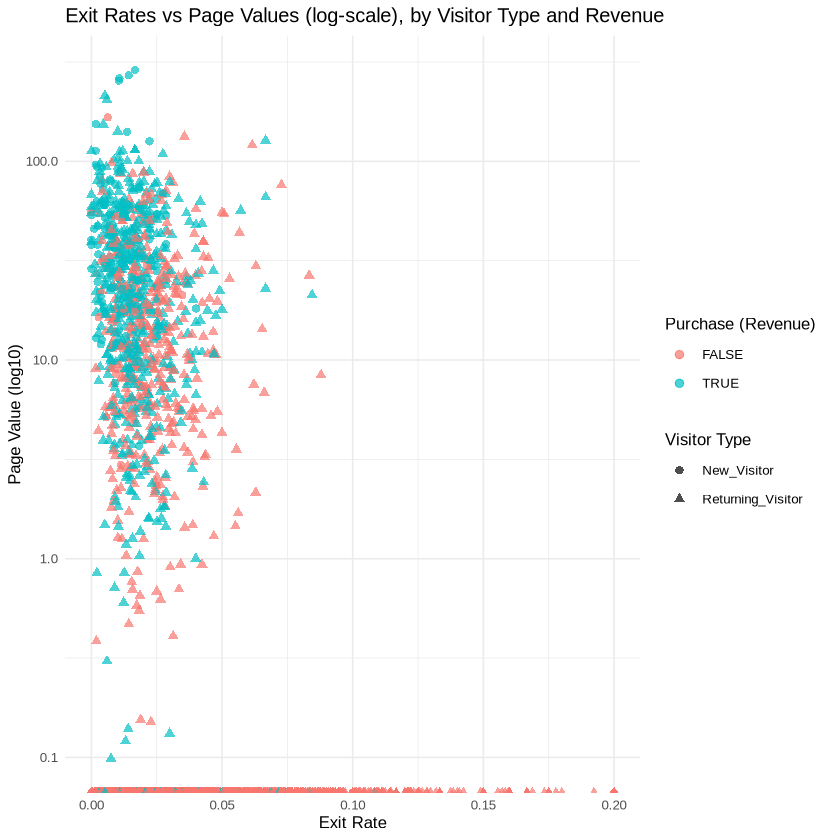

In [40]:
# Scatterplot of ExitRates vs PageValues
ggplot(osi, aes(x = ExitRates, y = PageValues,
                color = Revenue, shape = VisitorType)) +
  geom_point(alpha = 0.7, size = 2) +
  scale_y_log10() +     # log scale due to high skew in PageValues
  labs(
    title = "Exit Rates vs Page Values (log-scale), by Visitor Type and Revenue",
    x = "Exit Rate",
    y = "Page Value (log10)",
    color = "Purchase (Revenue)",
    shape = "Visitor Type"
  ) +
  theme_minimal(base_size = 10)


#### Visualization
We visualize `ExitRates` against `PageValues` (scaled by log10), with shape representing `VisitorType` and color representing `Revenue`.  
This scatterplot allows us to explore how both engagement indicators (ExitRates, PageValues) and visitor type interact with purchasing behavior.

#### Interpretation
A scatter plot is valid here because it can show the relationship between two numerical variables (`ExitRates` and `PageValues`) while encoding the categorical variable (VisitorType) through color or shape, and the binary outcome (Revenue) through size and color. This allows us to visually assess patterns, trends, or clusters that relate visitor behavior and characteristics to purchase likelihood.

We observed that sessions resulting in purchases (`Revenue = TRUE`) tend to have lower exit rates and higher page values.  

**However, from the scatterplot, it is not clearly visible that returning visitors have more purchase sessions than new visitors. The points representing purchases (Revenue = TRUE) are mixed between the two visitor types, and the overlap between shapes makes it difficult to visually compare their frequencies. The figure shows general patterns in ExitRates and PageValues for sessions that resulted in purchases, but it does not provide a clear visual separation between New_Visitor and Returning_Visitor in terms of purchase counts.**

### Section 4: Method and Plan

To investigate how browsing behaviour, visitor characteristics, and engagement metrics relate to the likelihood of making a purchase, we will use a logistic regression model. Since `Revenue` is a binary variable (TRUE/FALSE), logistic regression is an appropriate statistical method that models the probability of purchase as a function of multiple predictors.

**Why is this method appropriate?**  
Logistic regression is specifically designed for binary outcomes and allows us to interpret the effect of each explanatory variable on the log-odds of purchase.

**Assumptions required:**  
For this model we assumed that the observations are independent, the log-odds of the outcome is linearly related to the predictors, and no perfect multicollinearity among predictors (addressed earlier by removing highly correlated variables).

**Potential limitations:**  
Logistic regression may fail to capture nonlinear relationships or interactions between user behaviours. It can also be sensitive to imbalanced data (in our case, we have far more non-purchase sessions). If key behavioural patterns are nonlinear or complex, the model may oversimplify the underlying structure.

---

### Section 5: Computational Code and Output
Below we implement the logistic regression model described in Section 4.


In [44]:
# Fit logistic regression model
logit_model <- glm(
  Revenue ~ .,
  data = osi,
  family = binomial(link = "logit")
)

# Tidy results with odds ratios and confidence intervals
tidy_logit <- broom::tidy(logit_model, conf.int = TRUE)
tidy_logit

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-1.612494e+00,0.3256627133,-4.95142272,7.367288e-07,-2.268109e+00,-9.891531e-01
Administrative,-2.546608e-02,0.0172837727,-1.47340972,1.406406e-01,-5.964960e-02,8.166593e-03
Administrative_Duration,2.526391e-05,0.0002635307,0.09586702,9.236262e-01,-5.080002e-04,5.311526e-04
Informational,6.880619e-02,0.0402822840,1.70810059,8.761768e-02,-1.062313e-02,1.473730e-01
Informational_Duration,-1.586033e-04,0.0003414584,-0.46448805,6.422981e-01,-8.544382e-04,4.883432e-04
ProductRelated,5.067979e-03,0.0009095159,5.57217127,2.515839e-08,3.292296e-03,6.864021e-03
ExitRates,-1.917708e+01,2.8218748271,-6.79586577,1.076640e-11,-2.497341e+01,-1.392250e+01
PageValues,8.120501e-02,0.0037754728,21.50856834,1.294378e-102,7.397096e-02,8.877542e-02
SpecialDay,8.183494e-02,0.3916035480,0.20897395,8.344686e-01,-7.188203e-01,8.232546e-01


#### Interpretation:

The results show that **ExitRates** (log-odds = –19.18, p ≈ 1.1×10^-11) and **PageValues** (log-odds = 0.081, p ≈ 1.3×10^-102) are highly significant predictors, indicating that lower exit rates and higher page values strongly increase the odds of purchase. **Returning Visitor** (log-odds = –0.354, p = 0.0096) are also statistically significant, with returning visitors showing lower purchase odds. All remaining predictors have p-values above 0.05, meaning they do not show statistically meaningful effects on the log-odds of purchase. Overall, we were expected to see the model indicates that user engagement metrics and visitor type are the key drivers of purchase behavior.
